In [2]:
library('tidyverse')
library('rvest')
library('lubridate')
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
scrape_table = function(i, MF='WOMEN\'S') {
    url = "https://www.baa.org/races/boston-marathon/results/champions"
    webpage = xml2::read_html(url)
    tbl = html_nodes(webpage, "table")[[i]] %>%
        html_table() %>%
        drop_na() %>%
        magrittr::set_colnames(c('year', 'name', 'country', 'time')) %>%
        mutate(time = hms(time)) %>%
        mutate(year = as.Date(paste(year, 1, 1, sep = "-"))) %>%
        mutate(race.time = as.numeric(time, 'hours')) %>%
        mutate(MF = MF) %>%
        mutate(
            country.simple = ifelse(
                country %in% c('United States', 'Ethiopia', 'Japan', 'Kenya'),
                country,
                'other'
            )
        )
    tbl
}

df.men = scrape_table(1, MF='MEN\'S')
df.women = scrape_table(2)

df.marathon = rbind(df.men, df.women) |> mutate(MF = forcats::fct_relevel(MF, "WOMEN'S"))

In [4]:
levels(df.marathon$MF)

[1] "WOMEN'S" "MEN'S"

Let's re-create this chart from FiveThirtyEight

<center>
    <img src="https://fivethirtyeight.com/wp-content/uploads/2018/04/wezerek-marathon-0416-13.png"
         style="width: 600px;"/>
</center>

Preview the data (i.e. `df.marathon`).

Fill in the table below:

| chart property | column name |
| --- | --- |
| x value | year |
| y value | ? |
| color | ? |
| facet value | ? |

Make note of other aesthetic decisions. 
- What's the y-axis title?
- Do the two charts share the same x-axis bounds?
- Is there a legend?

Code your version of the chart below.

In [9]:
country_names = data.frame(
    country.simple = c('United States', 'Japan', 'Kenya', 'United States'),
    year = as.Date(c('1919-01-01', '1955-01-01', '1990-01-01', '1986-01-01')),
    time = duration(c(3, 2.15, 2.3, 2.75), 'hours'),
    MF = factor(c("MEN'S", "MEN'S", "MEN'S", "WOMEN'S"), levels = c("WOMEN'S", "MEN'S"))
)

country_names

country.simple,year,time,MF
<chr>,<date>,<Duration>,<fct>
United States,1919-01-01,10800s (~3 hours),MEN'S
Japan,1955-01-01,7740s (~2.15 hours),MEN'S
Kenya,1990-01-01,8280s (~2.3 hours),MEN'S
United States,1986-01-01,9900s (~2.75 hours),WOMEN'S


In [17]:
df.marathon |>
    filter(country.simple != 'other') |> #values in country can't equal other
    group_by(country.simple, MF) |> 
    summarize(year=mean(year), time=mean(time))
#summarize by mean of all years and mean of all times
# can place label in the mean spot

`summarise()` has grouped output by 'country.simple'. You can override using the `.groups` argument.



country.simple,MF,year,time
<chr>,<fct>,<date>,<dbl>
Ethiopia,WOMEN'S,2007-08-17,26.75000
Ethiopia,MEN'S,2007-11-01,29.50000
Japan,MEN'S,1971-09-01,38.33333
Kenya,WOMEN'S,2009-11-09,33.21429
Kenya,MEN'S,2003-07-17,30.33333
United States,WOMEN'S,1981-07-02,30.90000
United States,MEN'S,1935-02-03,27.47727


In [7]:
winners_2018 = df.marathon |> filter(year == '2018-01-01')

winners_2018

year,name,country,time,race.time,MF,country.simple
<date>,<chr>,<chr>,<Period>,<dbl>,<fct>,<chr>
2018-01-01,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,MEN'S,Japan
2018-01-01,Desiree Linden,United States,2H 39M 54S,2.665000,WOMEN'S,United States


In [12]:
library('ggrepel')

In [15]:
df.marathon$country.simple |> table() #similar to proc freq


     Ethiopia         Japan         Kenya         other United States 
           14             9            38            60            54 

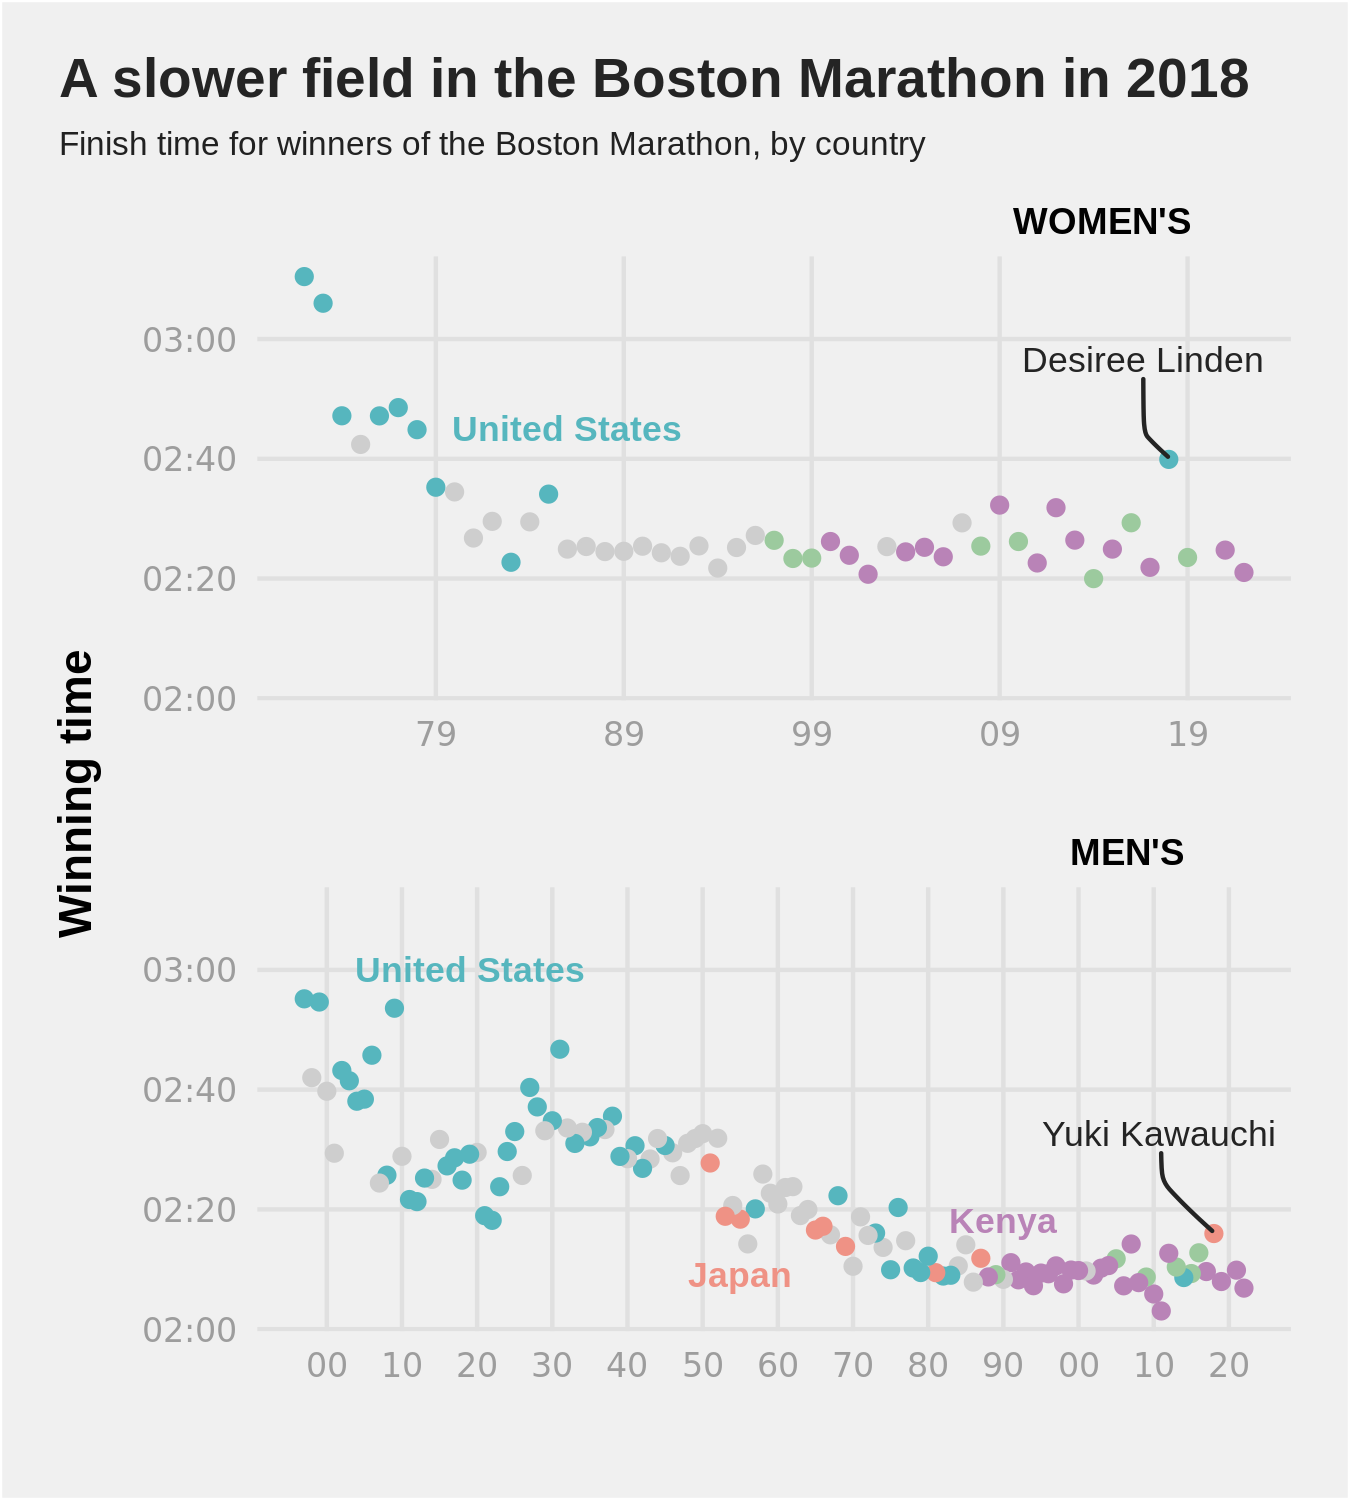

In [14]:
options(repr.plot.width = 4.5, repr.plot.height = 5)

bg = '#f0f0f0'
colors = c('#9cca9e', '#ef9285', '#b983b7', '#cecece', '#56b6be')


p = ggplot(df.marathon, aes(x = year, y = time, color = country.simple)) + 
    geom_point() +
    geom_text(data = country_names, fontface = 'bold', size = 3, aes(label = country.simple)) +
    geom_text_repel(
        data = winners_2018, 
        color = '#242424', 
        aes(label = name),
        nudge_x = -500,
        nudge_y = 1000,
        size = 3,
        segment.curvature = 0.1,
        segment.ncp = 3,
        segment.angle = 20
    ) +
    facet_wrap(~MF, ncol = 1, scales = 'free_x') +
    labs(title = 'A slower field in the Boston Marathon in 2018', 
         subtitle = 'Finish time for winners of the Boston Marathon, by country',
         y = 'Winning time', x = '') + 
    scale_y_time(labels = scales::label_time(format = '%H:%M')) +
    scale_x_date(date_breaks = "10 years", date_labels = "%y") +
    scale_color_manual(values = colors) +
    theme(legend.position = 'None',
          plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
          plot.subtitle = element_text(color = '#212121', size = 8),
          plot.title = element_text(color = '#242424', face = 'bold'),
          strip.text = element_text(hjust = 0.9, color = '#010101', face = 'bold'),
          plot.title.position = 'plot',
          plot.background = element_rect(fill = bg),
          panel.background = element_rect(fill = bg),
          strip.background = element_blank(),
          strip.placement = 'inside',
          panel.grid.major = element_line(color = '#e0e0e0'),
          panel.grid.minor = element_blank(),
          panel.spacing = unit(0.5, "cm"),
          axis.ticks = element_blank(),
          axis.title.y = element_text(face = 'bold', margin = margin(r = 10)),
          axis.text = element_text(color = '#9d9d9d', family = 'DecimaMonoPro', size = 8))

p

What else might you visualize with this data? (e.g. What about totaling the winners from each country?)